In [30]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import e3x
import jax
import jax.numpy as jnp
import numpy as np
from flax.training import orbax_utils
import orbax.checkpoint
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import py3Dmol
import matplotlib.pyplot as plt
from src.model import MessagePassingModel
from src.utils import prepare_datasets, MessagePassingCalculator, MOLECULE_CONFIG

Load the model that was trained using the `train_model.py` script.

In [2]:
molecule = "ethanol"
save_dir = MOLECULE_CONFIG[molecule]["save_dir"]

## Load the checkpoint model
# Model hyperparameters.
features = 32
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 5.0
message_passing_model = MessagePassingModel(
  features=features,
  max_degree=max_degree,
  num_iterations=num_iterations,
  num_basis_functions=num_basis_functions,
  cutoff=cutoff,
)
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
params = orbax_checkpointer.restore(save_dir)

## Load the training set
file_path = "../data/"+MOLECULE_CONFIG[molecule]["filename"]
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)
train_data, valid_data, _ = prepare_datasets(file_path, data_key)

In [17]:
# @jax.jit
def evaluate_energies_and_forces(atomic_numbers, positions, dst_idx, src_idx):
  return message_passing_model.apply(params,
    atomic_numbers=atomic_numbers,
    positions=positions,
    dst_idx=dst_idx,
    src_idx=src_idx,
  )


class MessagePassingCalculator(ase_calc.Calculator):
  implemented_properties = ["energy", "forces"]

  def calculate(self, atoms, properties, system_changes = ase.calculators.calculator.all_changes):
    ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
    dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(atoms))
    energy, forces = evaluate_energies_and_forces(
      atomic_numbers=atoms.get_atomic_numbers(),
      positions=atoms.get_positions(),
      dst_idx=dst_idx,
      src_idx=src_idx
    )
    self.results['energy'] = energy * ase.units.kcal/ase.units.mol
    self.results['forces'] = forces * ase.units.kcal/ase.units.mol

In [18]:
# Initialize atoms object and attach calculator.
atoms = ase.Atoms(train_data['atomic_numbers'], train_data['positions'][0])
atoms.set_calculator(MessagePassingCalculator())

# Run structure optimization with BFGS.
_ = ase_opt.BFGS(atoms).run(fmax=0.05)

      Step     Time          Energy         fmax
BFGS:    0 19:18:47        0.006124        0.0003


In [22]:
# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view = py3Dmol.view()
view.addModel(xyz.getvalue(), 'xyz')
view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [27]:
# Parameters.
temperature = 300
timestep_fs = 0.5
num_steps = 2000

# Draw initial momenta.
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
Stationary(atoms)  # Remove center of mass translation.
ZeroRotation(atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(atoms), 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = atoms.get_positions()
  potential_energy[i] = atoms.get_potential_energy()
  kinetic_energy[i] = atoms.get_kinetic_energy()
  total_energy[i] = atoms.get_total_energy()
  # Occasionally print progress.
  if i % 100 == 0:
    print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")

/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()


step     0 epot  0.006 ekin  0.337 etot  0.343


/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc

step   100 epot  0.007 ekin  0.336 etot  0.343


/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc

step   200 epot  0.007 ekin  0.336 etot  0.343


/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc

step   300 epot  0.007 ekin  0.337 etot  0.343


/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc

step   400 epot  0.007 ekin  0.337 etot  0.343


/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc

step   500 epot  0.007 ekin  0.337 etot  0.343


/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc

step   600 epot  0.007 ekin  0.337 etot  0.343


/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc

step   700 epot  0.007 ekin  0.337 etot  0.343


/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc

step   800 epot  0.007 ekin  0.337 etot  0.343


/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc

step   900 epot  0.007 ekin  0.337 etot  0.343


/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc

step  1000 epot  0.007 ekin  0.337 etot  0.343


/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc

step  1100 epot  0.007 ekin  0.337 etot  0.343


/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc

step  1200 epot  0.007 ekin  0.337 etot  0.343


/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc

step  1300 epot  0.007 ekin  0.337 etot  0.343


/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc

step  1400 epot  0.007 ekin  0.337 etot  0.343


/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc

step  1500 epot  0.007 ekin  0.337 etot  0.343


/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc

step  1600 epot  0.007 ekin  0.337 etot  0.343


/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc

step  1700 epot  0.007 ekin  0.337 etot  0.343


/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc

step  1800 epot  0.007 ekin  0.337 etot  0.343


/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc

step  1900 epot  0.007 ekin  0.337 etot  0.343


/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc0000gn/T/ipykernel_2015/642681450.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()
/var/folders/5l/5fh03_x97cnc70z_bb9lqgfc

In [28]:
view.getModel().setCoordinates(frames, 'array')
view.animate({'loop': 'forward', 'interval': 0.1})
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

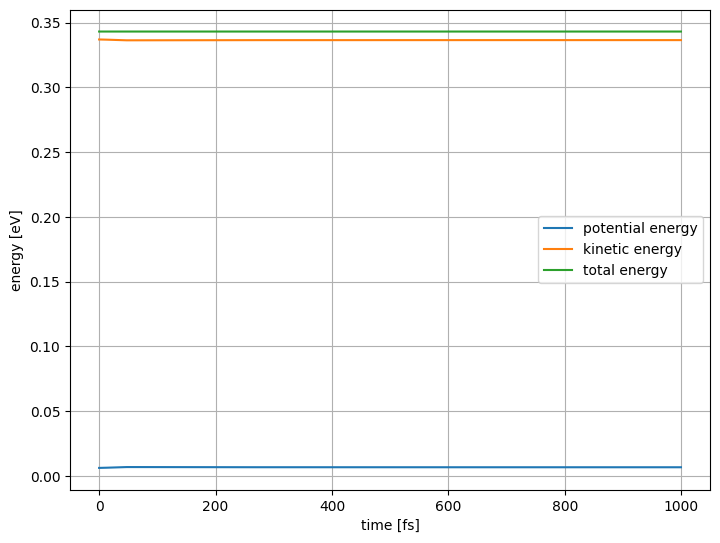

In [31]:
%matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy, label='potential energy')
plt.plot(time, kinetic_energy, label='kinetic energy')
plt.plot(time, total_energy, label='total energy')
plt.legend()
plt.grid()